**last update: 08/06/2024**  

This notebook is for Bayesian Gaussian process regression test.

Dataset: sythetic data with middle-range oscillations(decades). Annual mean. 100 models in total. Use first 16 models as example.

Design: Test different kernels with middle-range oscillation data and give evaluations, only for sum of periods.

Note: In this notebook, there is cross validation(leave-one-out). Only use the mean value of other models as prior and plot.

# Package

In [1]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, ConstantKernel as C
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, ParameterGrid
from scipy.optimize import minimize
from pyswarm import pso
from bayes_opt import BayesianOptimization
from scipy.linalg import cholesky, cho_solve,cho_factor,solve_triangular
from scipy.signal import periodogram, welch
from scipy.fft import fft
import pywt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, RationalQuadratic, DotProduct
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
from bayes_opt import BayesianOptimization, UtilityFunction
from properscoring import crps_gaussian
import gpflow
from gpflow.utilities import print_summary
from gpflow.kernels import RBF, Cosine, Product
from sklearn.preprocessing import StandardScaler

# Data

In [3]:
rainfall = pd.read_csv('../data/rainfall_m.csv')
mod_ids = range(0, 16)
selected_data = rainfall.iloc[:16, 1:]
years = (selected_data.shape[1] // 12)
rainfall_yearly = pd.DataFrame()
for i in range(years):
    rainfall_yearly[i] = selected_data.iloc[:, i*12:(i+1)*12].sum(axis=1)
rainfall_yearly = rainfall_yearly.T
rainfall_yearly.columns = [i+1 for i in range(rainfall_yearly.shape[1])]
rainfall_log = np.log(rainfall_yearly + 1) 
scaler = StandardScaler()
rainfall_yearly = pd.DataFrame(scaler.fit_transform(rainfall_log), columns=rainfall_log.columns)

rainfall_yearly

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-2.439274,1.174882,-0.733376,-0.521282,-1.100109,0.832297,-0.843171,-0.080403,1.918096,-0.136646,-0.036122,-0.464269,0.499056,0.926378,-2.760083,1.089781
1,-0.787676,1.246921,1.582399,0.639681,-0.829540,0.529371,-1.357066,-0.271575,1.486388,-1.128430,-0.299712,-0.778042,0.786228,-0.155227,-2.418165,1.794233
2,-1.279370,0.678254,0.171822,-1.283355,-0.220452,1.310369,-0.551705,-0.360746,1.531186,-1.384989,-0.411965,0.126760,-0.112411,-0.386841,-0.713558,1.899844
3,0.681263,0.318577,2.131191,-0.154067,-0.983916,0.547115,-0.977466,0.121726,0.047151,-2.210545,0.040223,-0.792175,0.230260,-0.649609,-0.557796,1.670634
4,0.824932,0.380310,-0.195647,-0.464396,0.327646,1.225606,0.040750,-0.209179,0.878397,-1.120644,-0.035942,1.310913,-0.933555,-0.995723,1.814829,1.172886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.120060,0.586151,-0.107641,2.273480,-0.260166,0.236297,0.158062,0.725141,-1.362798,0.601651,-0.114530,-1.538919,-1.937932,-0.838045,0.654972,0.295742
96,0.426730,0.372554,-0.813408,0.898837,-0.807246,1.180120,0.162345,-0.226970,0.445007,-0.899512,-0.104813,-2.664643,-2.224963,-1.306272,0.786511,-0.220555
97,-0.374703,0.555211,-0.663636,0.860059,-1.191125,-0.572383,-1.281685,-0.014722,-0.343058,-0.101647,-0.574291,-0.687258,-1.698157,-2.030745,0.580238,0.462812
98,-0.211841,0.084305,-1.462925,-1.274322,-0.777126,0.247174,-1.795521,-0.920524,0.778060,-0.977654,-0.210234,-1.209678,-1.224903,-1.977816,0.813549,-0.028114


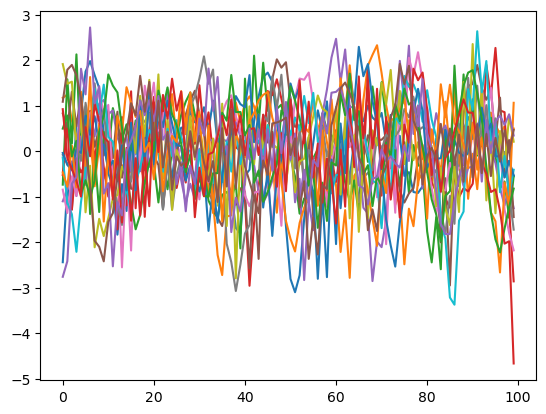

In [4]:
plt.plot(rainfall_yearly)

# Periodic Analysis

In [5]:
# Function to plot and return the top 3 periodicities for each method
def analyze_periodicity(data):
    results = {}
    
    # Convert data to numpy array for FFT
    data = np.asarray(data)
    
    # Fourier Transform
    N = len(data)
    T = 1.0
    yf = fft(data)
    xf = np.fft.fftfreq(N, T)[:N//2]
    fft_amplitudes = 2.0/N * np.abs(yf[0:N//2])
    
    # Avoid division by zero
    non_zero_freqs = xf != 0
    xf = xf[non_zero_freqs]
    fft_amplitudes = fft_amplitudes[non_zero_freqs]
    
    fft_peaks = np.argsort(fft_amplitudes)[-3:]
    fft_periods = 1 / xf[fft_peaks]
    results['FFT'] = fft_periods
    
    # Wavelet Transform
    widths = np.arange(1, 31)
    cwt_matr = pywt.cwt(data, widths, 'mexh')[0]
    wavelet_power = np.sum(cwt_matr**2, axis=1)
    wavelet_peaks = np.argsort(wavelet_power)[-3:]
    wavelet_periods = widths[wavelet_peaks]
    results['Wavelet'] = wavelet_periods
    
    # Autocorrelation
    autocorr = acf(data, nlags=N//2)
    autocorr_peaks = np.argsort(autocorr)[-3:]
    results['Autocorrelation'] = autocorr_peaks
    
    # Power Spectral Density
    freqs, psd = periodogram(data)
    non_zero_freqs = freqs != 0
    freqs = freqs[non_zero_freqs]
    psd = psd[non_zero_freqs]
    
    psd_peaks = np.argsort(psd)[-3:]
    psd_periods = 1 / freqs[psd_peaks]
    results['PSD'] = psd_periods
    
    return results

# Perform the analysis for each of the 16 models
all_results = []
for col in rainfall_yearly.columns:
    data = rainfall_yearly[col]
    results = analyze_periodicity(data)
    all_results.append(results)

# Aggregate and print the results
for method in ['FFT', 'Wavelet', 'Autocorrelation', 'PSD']:
    print(f"Top 3 periodicities for {method}:")
    for i, result in enumerate(all_results):
        print(f"Model {i+1}: {result[method]}")
    print("\n")

Top 3 periodicities for FFT:
Model 1: [20.  10.  12.5]
Model 2: [25.         12.5        14.28571429]
Model 3: [ 2.17391304 20.         14.28571429]
Model 4: [ 2.17391304 25.         14.28571429]
Model 5: [12.5        16.66666667 14.28571429]
Model 6: [50.         14.28571429 20.        ]
Model 7: [ 8.33333333 16.66666667 14.28571429]
Model 8: [12.5        20.         14.28571429]
Model 9: [25.          2.04081633 14.28571429]
Model 10: [ 9.09090909 16.66666667 14.28571429]
Model 11: [20.         12.5        14.28571429]
Model 12: [ 2.22222222 20.         14.28571429]
Model 13: [16.66666667 14.28571429 12.5       ]
Model 14: [ 2.12765957 16.66666667 14.28571429]
Model 15: [12.5         9.09090909 14.28571429]
Model 16: [20.         12.5        14.28571429]


Top 3 periodicities for Wavelet:
Model 1: [5 4 3]
Model 2: [5 3 4]
Model 3: [3 5 4]
Model 4: [6 5 4]
Model 5: [3 5 4]
Model 6: [4 6 5]
Model 7: [5 3 4]
Model 8: [3 5 4]
Model 9: [6 5 4]
Model 10: [5 3 4]
Model 11: [5 3 4]
Model 12:

significant periods: [10, 30]

In [6]:
oos_gcm = rainfall_yearly.iloc[:,0].values
oos_gcm

array([-2.43927392, -0.78767647, -1.27937042,  0.68126317,  0.82493237,
        1.75299027,  1.98436921,  1.67404208,  1.39050444,  0.38727728,
       -0.48151018, -0.78681791, -1.83294007, -0.72183621, -1.31199284,
        0.04952879, -0.06237537,  0.61237585,  0.54085534,  0.41096063,
       -0.2204582 ,  0.12004264, -1.26046982, -0.05358961, -0.58555448,
        0.21390608,  0.51890751,  0.52498047,  0.86293786,  0.63782044,
        0.64072302,  0.96889305,  0.46687698,  1.11317883,  0.16449047,
        0.49831575, -0.6552975 , -0.91153417, -1.68640086, -1.80879567,
       -0.53732524, -0.40424406,  0.65592537,  1.20813027,  1.63320693,
        1.73045899,  1.53057614,  0.69869516, -0.19514381, -1.64615297,
       -2.80804055, -3.09892451, -2.72714784, -1.48972802, -0.51802733,
        0.19208176,  0.90122631,  0.45031685,  1.09807396, -0.1836069 ,
        0.26314798, -1.25142829, -0.09561337, -0.59698545,  0.25771731,
        0.61775704,  0.66675827,  1.00431578,  0.74346301,  0.64

# Function

## tuning

In [7]:
def tune_GPR(mod_ids, Nobs, data, pbounds, kernel_func):
    def gp_target(**params):
        total_lml = 0.0
        
        for mod_id in mod_ids:
            if mod_id >= data.shape[1]:
                print(f"mod_id {mod_id} is out of bounds for data with {data.shape[1]} columns.")
                continue
            
            try:
                oos_gcm = data.iloc[:, mod_id].values
            except IndexError as e:
                print(f"IndexError for mod_id {mod_id}: {e}")
                continue

            X_train = np.arange(Nobs).reshape(-1, 1).astype(float)
            y_train = oos_gcm[:Nobs]

            kernel = kernel_func(params)
            gp = GaussianProcessRegressor(kernel=kernel, optimizer=None)
            
            try:
                gp.fit(X_train, y_train)
                lml = gp.log_marginal_likelihood()
                
                if np.isreal(lml):
                    total_lml += lml
                else:
                    total_lml -= np.inf
            except np.linalg.LinAlgError as e:
                total_lml -= np.inf

        return total_lml
    
    optimizer = BayesianOptimization(f=gp_target, pbounds=pbounds, random_state=42)
    
    init_points = 100
    n_iter = 100

    with tqdm(total=init_points + n_iter, desc="Optimization Progress") as pbar:
        try:
            optimizer.maximize(init_points=init_points, n_iter=n_iter)
            pbar.update(init_points + n_iter)
        except Exception as e:
            print("An error occurred during optimization:", e)
            if 'params' in optimizer.max:
                best_params = optimizer.max['params']
                print("Best parameters found during the optimization process: ", best_params)
                kernel = kernel_func(best_params)
                return kernel
            else:
                print("No valid parameters found during the optimization process.")
                return None
    
    try:
        best_params = optimizer.max['params']
        print("Best parameters found: ", best_params)
        kernel = kernel_func(best_params)
        return kernel
    except KeyError:
        print("No valid parameters found after the optimization process.")
        return None

## calculate mean and std

### calculate posterior

In [11]:
def GPR_func_sklearn(Nobs, data, best_kernel):
    np.float = np.float64
    smoothedMean = np.mean(data, axis=1)
    X_train = np.arange(Nobs).reshape(-1, 1)
    y_train = smoothedMean[:Nobs]
    X_test = np.arange(Nobs, len(data)).reshape(-1, 1)
    y_test = smoothedMean[Nobs:]
    X_full = np.arange(len(data)).reshape(-1, 1)
    y_full = smoothedMean
    mu = smoothedMean[:Nobs] #prior estimate mean(up to observations)
    mu_s = smoothedMean[Nobs:]  # prior estimate mean (whole study period)

    
    gp = GaussianProcessRegressor(kernel=best_kernel, optimizer=None)
    gp.fit(X_train, y_train)
    print("best_kernel:", best_kernel)

    lml_train = log_marginal_likelihood_partial(gp, X_train, y_train)
    print("lml_train:", lml_train)
    lml_test = log_marginal_likelihood_partial(gp, X_test, y_test)
    print("lml_test:", lml_test)
    lml_full = log_marginal_likelihood_partial(gp, X_full, y_full)
    print("lml_full:", lml_full)
    
    prior_mu = smoothedMean
    prior_cov = gp.kernel_(X_full, X_full)
    post_mu, post_cov = gp.predict(X_full, return_cov=True) 
    
    return prior_mu, prior_cov, post_mu, post_cov

### use gp to obtain posterior

In [10]:
def log_marginal_likelihood_partial(gp, X, y):
    """
    Compute the log marginal likelihood for a given subset of data using a fitted Gaussian Process.
    """
    K = gp.kernel_(X)
    K[np.diag_indices_from(K)] += gp.alpha
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    
    log_likelihood = -0.5 * np.dot(y.T, alpha)
    log_likelihood -= np.sum(np.log(np.diag(L)))
    log_likelihood -= len(X) / 2 * np.log(2 * np.pi)
    
    return log_likelihood

## plot

In [12]:
def plot_gpr_results(Nobs, data, best_kernel):
    prior_mu, prior_cov, post_mu, post_cov = GPR_func_sklearn(Nobs, data, best_kernel)
    prior_std = np.sqrt(np.diag(prior_cov))
    post_std = np.sqrt(np.diag(post_cov))
    # prior_mu_obs = prior_mu[:Nobs]

    plt.figure()
    # plt.plot(np.arange(Nobs), prior_mu_obs, 'k', lw=1, label='Prior Observation Mean')
    # plt.fill_between(np.arange(len(data)), prior_mu - 1.96 * prior_std, prior_mu + 1.96 * prior_std, alpha=0.3, color='gray')
    t_pred = np.arange(len(data))
    post_mu_pred = post_mu
    post_std_pred = post_std
    
    plt.axvline(x=Nobs, color='grey', linestyle='--', label='Training/Test Split')
    plt.plot(rainfall_yearly, alpha=0.1, color='blue') #imitate prior region
    plt.fill_between(t_pred, post_mu_pred - 1.96 * post_std_pred, post_mu_pred + 1.96 * post_std_pred, alpha=0.1, color='r', label='95% Posterior Mean')
    plt.plot(t_pred, prior_mu, 'b', lw=2, label='Prior Observation Mean',alpha=1)
    plt.plot(t_pred, post_mu_pred, 'r', lw=2, label='Posterior Mean',alpha=0.6)
    
    
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Values")
    # plt.ylim(-5, 5)
    plt.title(f'GPR prediction with {Nobs} years for training')
    plt.show()

## combination

In [13]:
def gpr_model(mod_ids, Nobs, data, pbounds, kernel_func):
    np.float = np.float64
    best_kernel = tune_GPR(mod_ids, Nobs, data, pbounds, kernel_func)
    plot_gpr_results(Nobs, data, best_kernel)

# kernel

Test different kernels. Note that '_' means the sum of kernel, and kernel1kernel2 means kernel1*kernel2. Number means how many kernels we use of the same structure.

## sum of periods

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    c5     | dp_sig... |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |   per3    | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.991e+0 |  3.808    |  9.512    |  7.347    |  6.027    |  1.645    |  1.561    |  0.5903   |  8.663    |  6.015    |  7.081    |  10.41    |  29.4     |  26.65    |  21.24    |  1.826    |
|  2        | -2.9e+03  |  1.916    |  3.112    |  5.295    |  4.376    |  2.983    |  6.119    |  1.404    |  2.929    |  3.67     |  4.561    |  25.7     |  13.99    |  20.28    |  59.25    |  0.474    |
|  3        | -2.875e+0 |  6.115    |  1.788    |  0.744    |  9.494    |  9.66     |  8.084    |  3.053    |  0.9857   |  6.845    |  4.402    |  12.44    |  19.9     |  10.69

Optimization Progress:   0%|          | 0/200 [00:09<?, ?it/s]

|  99       | -2.704e+0 |  5.713    |  7.411    |  8.797    |  4.101    |  3.338    |  6.676    |  8.08     |  7.625    |  7.98     |  4.356    |  26.36    |  12.4     |  20.89    |  0.5858   |  3.253    |
|  100      | -2.865e+0 |  3.728    |  4.022    |  6.985    |  3.947    |  4.542    |  2.376    |  3.739    |  2.28     |  0.7412   |  6.035    |  23.36    |  22.39    |  19.27    |  37.98    |  8.635    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 3.62412951864749, 'c2': 7.602676493597254, 'c3': 0.2424955374345831, 'c4': 1.2491191410184708, 'c5': 0.5554261560153523, 'dp_sigma_0': 0.40824729438738244, 'ls1': 8.556051234269962, 'ls2': 7.039542015206436, 'ls3': 4.746996552582378, 'noise': 0.9792437723493639, 'per1': 19.832317502336647, 'per2': 19.469435415611315, 'per3': 13.464037398200304, 'rq_alpha': 43.39082640730492, 'rq_ls': 3.9910622966297606}
best_kernel: 1.9**2 * DotProduct(sigma_0=0.4

lml_train: -100.42448203804399
lml_test: -34.878978863318665
lml_full: -123.40733273872124


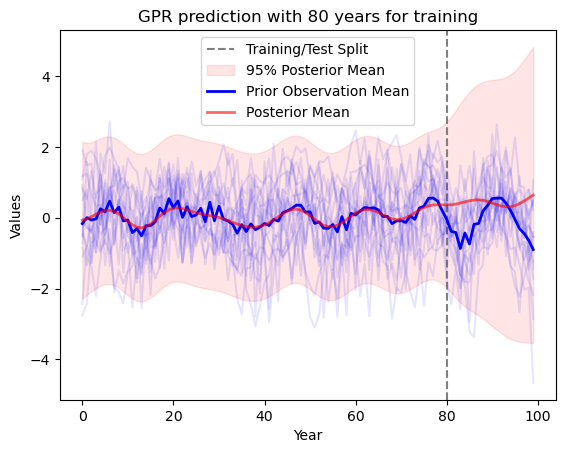

In [14]:
def create_kernel(best_params):
    kernel = (
        C(best_params['c1']) * (DotProduct(sigma_0=best_params['dp_sigma_0']) ** 2) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        C(best_params['c4']) * ExpSineSquared(length_scale=best_params['ls3'], periodicity=best_params['per3']) +
        C(best_params['c5']) * RationalQuadratic(length_scale=best_params['rq_ls'], alpha=best_params['rq_alpha']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'c5': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'per3': (10, 30),
    'noise': (1e-3, 1e1),
    'dp_sigma_0': (1e-3, 1e1),
    'rq_alpha': (1e-2, 1e2),
    'rq_ls': (1e-2, 1e1),
}
gpr_model(mod_ids, 80, rainfall_yearly, pbounds, create_kernel)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    c5     | dp_sig... |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |   per3    | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.991e+0 |  3.808    |  9.512    |  7.347    |  6.027    |  1.645    |  1.561    |  0.5903   |  8.663    |  6.015    |  7.081    |  10.41    |  29.4     |  26.65    |  21.24    |  1.826    |
|  2        | -2.9e+03  |  1.916    |  3.112    |  5.295    |  4.376    |  2.983    |  6.119    |  1.404    |  2.929    |  3.67     |  4.561    |  25.7     |  13.99    |  20.28    |  59.25    |  0.474    |
|  3        | -2.875e+0 |  6.115    |  1.788    |  0.744    |  9.494    |  9.66     |  8.084    |  3.053    |  0.9857   |  6.845    |  4.402    |  12.44    |  19.9     |  10.69

Optimization Progress:   0%|          | 0/200 [00:09<?, ?it/s]

|  100      | -2.865e+0 |  3.728    |  4.022    |  6.985    |  3.947    |  4.542    |  2.376    |  3.739    |  2.28     |  0.7412   |  6.035    |  23.36    |  22.39    |  19.27    |  37.98    |  8.635    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 3.62412951864749, 'c2': 7.602676493597254, 'c3': 0.2424955374345831, 'c4': 1.2491191410184708, 'c5': 0.5554261560153523, 'dp_sigma_0': 0.40824729438738244, 'ls1': 8.556051234269962, 'ls2': 7.039542015206436, 'ls3': 4.746996552582378, 'noise': 0.9792437723493639, 'per1': 19.832317502336647, 'per2': 19.469435415611315, 'per3': 13.464037398200304, 'rq_alpha': 43.39082640730492, 'rq_ls': 3.9910622966297606}
best_kernel: 1.9**2 * DotProduct(sigma_0=0.408) ** 2 + 2.76**2 * ExpSineSquared(length_scale=8.56, periodicity=19.8) + 0.492**2 * ExpSineSquared(length_scale=7.04, periodicity=19.5) + 1.12**2 * ExpSineSquared(length_scale=4.75, periodicity=13.5) + 0.

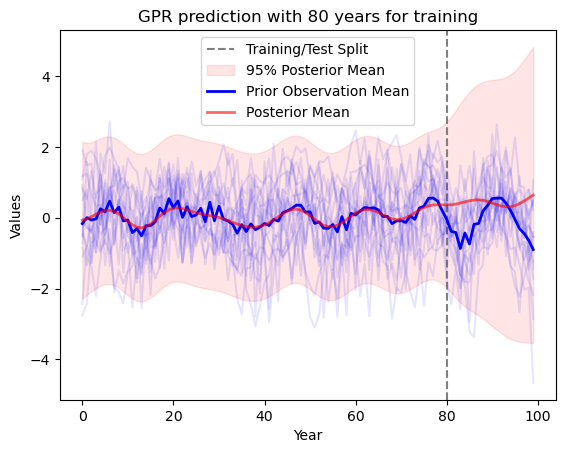

In [15]:
def pe3_poly_rq(best_params):
    kernel = (
        C(best_params['c1']) * (DotProduct(sigma_0=best_params['dp_sigma_0']) ** 2) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        C(best_params['c4']) * ExpSineSquared(length_scale=best_params['ls3'], periodicity=best_params['per3']) +
        C(best_params['c5']) * RationalQuadratic(length_scale=best_params['rq_ls'], alpha=best_params['rq_alpha']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
        'c1': (1e-1, 1e1),
        'c2': (1e-1, 1e1),
        'c3': (1e-1, 1e1),
        'c4': (1e-1, 1e1),
        'c5': (1e-1, 1e1),
        'ls1': (1e-2, 1e1),
        'per1': (10, 30),
        'ls2': (1e-2, 1e1),
        'per2': (10, 30),
        'ls3': (1e-2, 1e1),
        'per3': (10, 30),
        'noise': (1e-3, 1e1),
        'dp_sigma_0': (1e-3, 1e1),
        'rq_alpha': (1e-2, 1e2),
        'rq_ls': (1e-2, 1e1),
    }
gpr_model(mod_ids, 80, rainfall_yearly, pbounds, pe3_poly_rq)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]


|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    c5     | dp_sig... |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |   per3    |   rbf_c   |  rbf_ls   | rq_alpha1 | rq_alpha2 | rq_alpha3 |  rq_ls1   |  rq_ls2   |  rq_ls3   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
An error occurred during optimization: Unknown keyword argument: length_scale
No valid parameters found during the optimization process.
best_kernel: None
lml_train: -54.98206250317575
lml_test: -15.002242761986691
lml_full: -69.55554388453209


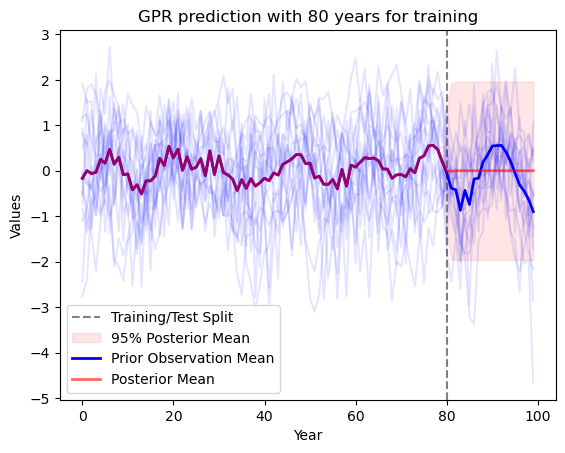

In [16]:
def rqpe2_poly_rq(best_params):
    kernel = (
        C(best_params['c1']) * (DotProduct(sigma_0=best_params['dp_sigma_0']) ** 2) +
        C(best_params['c2']) * RationalQuadratic(length_scale=best_params['rq_ls1'], alpha=best_params['rq_alpha1']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) * RationalQuadratic(length_scale=best_params['rq_ls2'], alpha=best_params['rq_alpha2']) +
        C(best_params['c4']) * ExpSineSquared(length_scale=best_params['ls3'], periodicity=best_params['per3']) * RationalQuadratic(length_scale=best_params['rq_ls3'], alpha=best_params['rq_alpha3']) +
        C(best_params['c5']) * RationalQuadratic(length_scale=best_params['rq_ls1'], alpha=best_params['rq_alpha1']) + C(best_params['rbf_c']) * RBF(length_scale=best_params['rbf_ls']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'c5': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'per3': (10, 30),
    'noise': (1e-3, 1e1),
    'dp_sigma_0': (1e-3, 1e1),
    'rq_alpha1': (1e-2, 1e2),
    'rq_ls1': (1e-2, 1e1),
    'rq_alpha2': (1e-2, 1e2),
    'rq_ls2': (1e-2, 1e1),
    'rq_alpha3': (1e-2, 1e2),
    'rq_ls3': (1e-2, 1e1),
    'rbf_c': (1e-1, 1e1),
    'rbf_ls': (1e-2, 1e1),
}
gpr_model(mod_ids, 80, rainfall_yearly, pbounds, rqpe2_poly_rq)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |   per3    |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.207e+0 |  3.808    |  9.512    |  7.323    |  5.991    |  1.569    |  1.561    |  11.16    |  27.32    |  22.02    |
|  2        | -2.173e+0 |  7.11     |  0.3038   |  9.699    |  8.326    |  2.131    |  1.819    |  13.67    |  16.08    |  20.5     |
|  3        | -2.463e+0 |  4.376    |  2.983    |  6.122    |  1.404    |  2.929    |  3.664    |  19.12    |  25.7     |  13.99    |
|  4        | -2.033e+0 |  5.191    |  5.965    |  0.474    |  6.079    |  1.714    |  0.6515   |  28.98    |  29.31    |  26.17    |
|  5        | -2.595e+0 |  3.116    |  1.067    |  6.845    |  4.407    |  1.229    |  4.952    |  10.69    |  28.19    |  15.18    |
|  6        | -2.973e+0 |  6.659    |  3.186    |  5.205    | 

Optimization Progress:   0%|          | 0/200 [00:07<?, ?it/s]

|  99       | -2.198e+0 |  0.2951   |  1.131    |  8.001    |  1.794    |  6.531    |  2.383    |  11.99    |  14.86    |  24.45    |
|  100      | -2.444e+0 |  8.571    |  8.319    |  3.978    |  6.684    |  2.058    |  2.932    |  27.93    |  10.26    |  11.71    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 3.631857934266534, 'c2': 2.8812516459050697, 'ls1': 5.431533870750902, 'ls2': 1.4178330074978789, 'ls3': 8.023947837732857, 'noise': 0.7464318861540284, 'per1': 29.737738732010346, 'per2': 25.444895385933147, 'per3': 13.974313630683447}
best_kernel: 1.91**2 * DotProduct(sigma_0=1) ** 2 + 1.7**2 * ExpSineSquared(length_scale=5.43, periodicity=29.7) + 1.7**2 * ExpSineSquared(length_scale=1.42, periodicity=25.4) + 1.7**2 * ExpSineSquared(length_scale=8.02, periodicity=14) + WhiteKernel(noise_level=0.746)
lml_train: -91.32636116516127


lml_test: -34.12455010657115
lml_full: -110.4598493157541


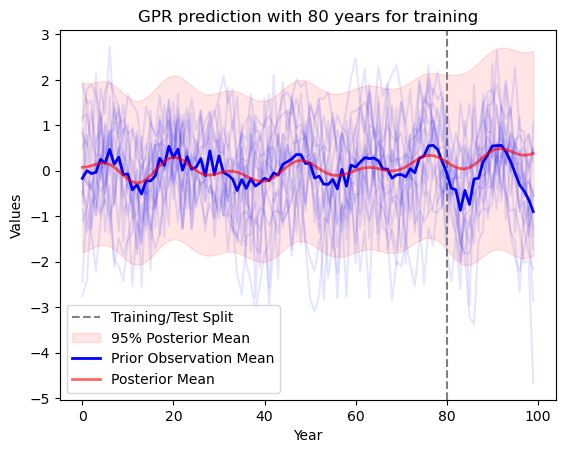

In [17]:
def pe3_poly(best_params):
    kernel = (
        C(best_params['c1']) * (DotProduct() ** 2) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls3'], periodicity=best_params['per3']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'per3': (10, 30),
    'noise': (1e-3, 1e1),
}
gpr_model(mod_ids, 80, rainfall_yearly, pbounds, pe3_poly)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]


|   iter    |  target   |    c1     |    c2     |    c3     |    c4     | dp_sig... |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |   per3    |  rbf_ls   | rbf_rq_c  | rq_alpha1 | rq_alpha2 | rq_alpha3 | rq_alp... |  rq_ls1   |  rq_ls2   |  rq_ls3   | rq_ls_rbf |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
An error occurred during optimization: Unknown keyword argument: length_scale
No valid parameters found during the optimization process.
best_kernel: None
lml_train: -54.98206250317575
lml_test: -15.002242761986691
lml_full: -69.55554388453209


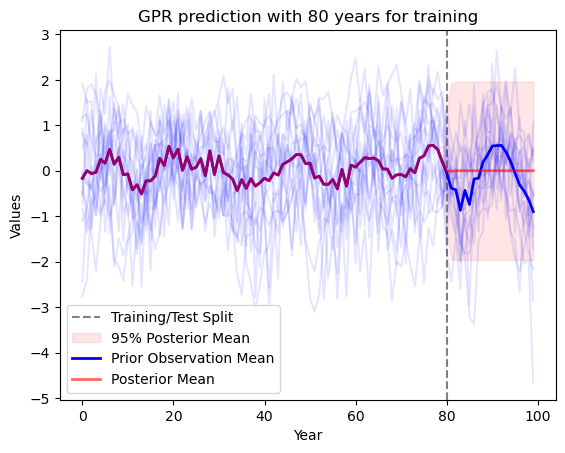

In [18]:
def rqpe3_poly_rqrbf(best_params):
    kernel = (
        C(best_params['c1']) * (DotProduct(sigma_0=best_params['dp_sigma_0']) ** 2) +
        C(best_params['c2']) * RationalQuadratic(length_scale=best_params['rq_ls1'], alpha=best_params['rq_alpha1']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) * RationalQuadratic(length_scale=best_params['rq_ls2'], alpha=best_params['rq_alpha2']) +
        C(best_params['c4']) * ExpSineSquared(length_scale=best_params['ls3'], periodicity=best_params['per3']) * RationalQuadratic(length_scale=best_params['rq_ls3'], alpha=best_params['rq_alpha3']) +
        C(best_params['rbf_rq_c']) * RBF(length_scale=best_params['rbf_ls']) * RationalQuadratic(length_scale=best_params['rq_ls_rbf'], alpha=best_params['rq_alpha_rbf']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'per3': (10, 30),
    'noise': (1e-3, 1e1),
    'dp_sigma_0': (1e-3, 1e1),
    'rq_alpha1': (1e-2, 1e2),
    'rq_ls1': (1e-2, 1e1),
    'rq_alpha2': (1e-2, 1e2),
    'rq_ls2': (1e-2, 1e1),
    'rq_alpha3': (1e-2, 1e2),
    'rq_ls3': (1e-2, 1e1),
    'rbf_rq_c': (1e-1, 1e1),
    'rbf_ls': (1e-2, 1e1),
    'rq_alpha_rbf': (1e-2, 1e2),
    'rq_ls_rbf': (1e-2, 1e1),
}
gpr_model(mod_ids, 80, rainfall_yearly, pbounds, rqpe3_poly_rqrbf)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]


|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    c5     |    c6     |    ls1    |    ls2    |    ls3    |    ls4    |    ls5    |   noise   |   per1    |   per2    |   per3    |  rbf_ls   | rbf_rq_c  | rq_alpha1 | rq_alp... |  rq_ls1   | rq_ls_rbf |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
An error occurred during optimization: Unknown keyword argument: length_scale
No valid parameters found during the optimization process.
best_kernel: None
lml_train: -54.98206250317575
lml_test: -15.002242761986691
lml_full: -69.55554388453209


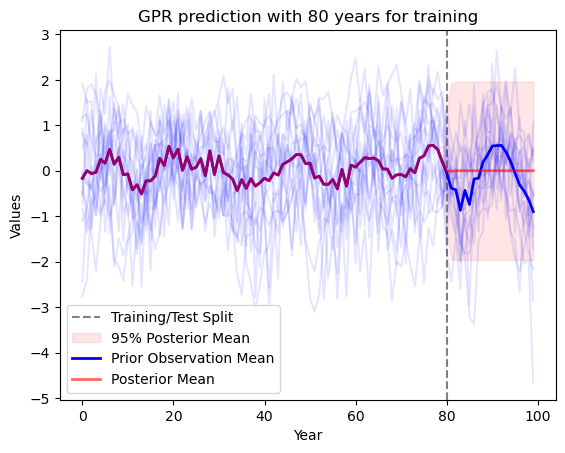

In [19]:
def pe3_rbf2_rqrbf_rq(best_params):
    kernel = (
        C(best_params['c1']) * RationalQuadratic(length_scale=best_params['rq_ls1'], alpha=best_params['rq_alpha1']) +
        C(best_params['rbf_rq_c']) * RBF(length_scale=best_params['rbf_ls']) * RationalQuadratic(length_scale=best_params['rq_ls_rbf'], alpha=best_params['rq_alpha_rbf']) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        C(best_params['c4']) * ExpSineSquared(length_scale=best_params['ls3'], periodicity=best_params['per3']) +
        C(best_params['c5']) * RBF(length_scale=best_params['ls4']) +
        C(best_params['c6']) * RBF(length_scale=best_params['ls5']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'c5': (1e-1, 1e1),
    'c6': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'per3': (10, 30),
    'ls4': (1e-2, 1e1),
    'ls5': (1e-2, 1e1),
    'noise': (1e-3, 1e1),
    'rq_alpha1': (1e-2, 1e2),
    'rq_ls1': (1e-2, 1e1),
    'rbf_rq_c': (1e-1, 1e1),
    'rbf_ls': (1e-2, 1e1),
    'rq_alpha_rbf': (1e-2, 1e2),
    'rq_ls_rbf': (1e-2, 1e1),
}

gpr_model(mod_ids, 80, rainfall_yearly, pbounds, pe3_rbf2_rqrbf_rq)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]


|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    c5     |    ls1    |    ls2    |    ls3    |    ls4    |   noise   |   per1    |   per2    |  rbf_ls   | rbf_rq_c  | rq_alpha1 | rq_alp... |  rq_ls1   | rq_ls_rbf |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
An error occurred during optimization: Unknown keyword argument: length_scale
No valid parameters found during the optimization process.
best_kernel: None
lml_train: -54.98206250317575
lml_test: -15.002242761986691
lml_full: -69.55554388453209


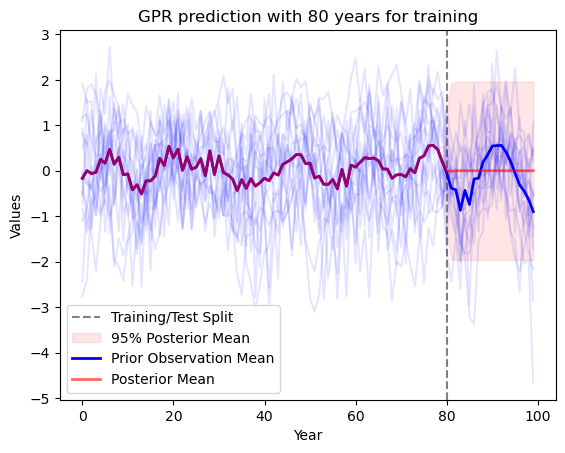

In [20]:
def pe2_rbf2_rqrbf_rq(best_params):
    kernel = (
        C(best_params['c1']) * RationalQuadratic(length_scale=best_params['rq_ls1'], alpha=best_params['rq_alpha1']) +
        C(best_params['rbf_rq_c']) * RBF(length_scale=best_params['rbf_ls']) * RationalQuadratic(length_scale=best_params['rq_ls_rbf'], alpha=best_params['rq_alpha_rbf']) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        C(best_params['c4']) * RBF(length_scale=best_params['ls3']) +
        C(best_params['c5']) * RBF(length_scale=best_params['ls4']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'c5': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'ls4': (1e-2, 1e1),
    'noise': (1e-3, 1e1),
    'rq_alpha1': (1e-2, 1e2),
    'rq_ls1': (1e-2, 1e1),
    'rbf_rq_c': (1e-1, 1e1),
    'rbf_ls': (1e-2, 1e1),
    'rq_alpha_rbf': (1e-2, 1e2),
    'rq_ls_rbf': (1e-2, 1e1),
}

gpr_model(mod_ids, 80, rainfall_yearly, pbounds, pe2_rbf2_rqrbf_rq)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]


|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |  rbf_ls   | rbf_rq_c  | rq_alpha1 | rq_alp... |  rq_ls1   | rq_ls_rbf |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
An error occurred during optimization: Unknown keyword argument: length_scale
No valid parameters found during the optimization process.
best_kernel: None
lml_train: -54.98206250317575
lml_test: -15.002242761986691
lml_full: -69.55554388453209


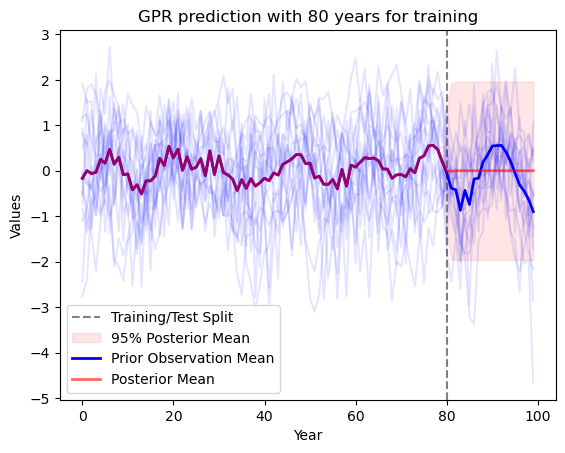

In [21]:
def pe2_rbf1_rqrbf_rq(best_params):
    kernel = (
        C(best_params['c1']) * RationalQuadratic(length_scale=best_params['rq_ls1'], alpha=best_params['rq_alpha1']) +
        C(best_params['rbf_rq_c']) * RBF(length_scale=best_params['rbf_ls']) * RationalQuadratic(length_scale=best_params['rq_ls_rbf'], alpha=best_params['rq_alpha_rbf']) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        C(best_params['c4']) * RBF(length_scale=best_params['ls3']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'noise': (1e-3, 1e1),
    'rq_alpha1': (1e-2, 1e2),
    'rq_ls1': (1e-2, 1e1),
    'rbf_rq_c': (1e-1, 1e1),
    'rbf_ls': (1e-2, 1e1),
    'rq_alpha_rbf': (1e-2, 1e2),
    'rq_ls_rbf': (1e-2, 1e1),
}

gpr_model(mod_ids, 80, rainfall_yearly, pbounds, pe2_rbf1_rqrbf_rq)


Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]


|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |  rbf_ls1  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
An error occurred during optimization: Unknown keyword argument: length_scale
No valid parameters found during the optimization process.
best_kernel: None
lml_train: -54.98206250317575
lml_test: -15.002242761986691
lml_full: -69.55554388453209


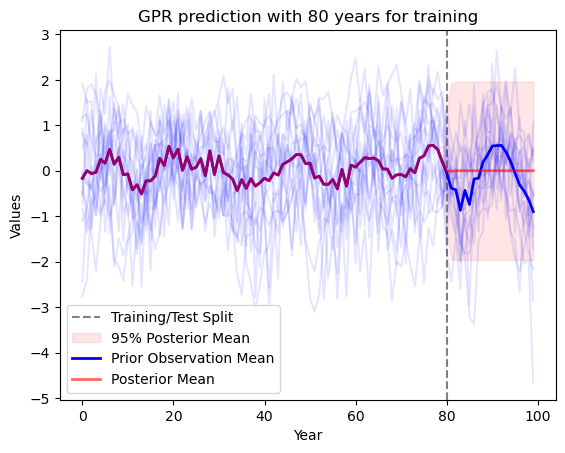

In [22]:
def pe2_rbf2(best_params):
    kernel = (
        C(best_params['c1']) * RBF(length_scale=best_params['rbf_ls1']) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        C(best_params['c4']) * RBF(length_scale=best_params['ls3']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'rbf_ls1': (1e-2, 1e1),
    'noise': (1e-3, 1e1)
}

gpr_model(mod_ids, 80, rainfall_yearly, pbounds, pe2_rbf2)